In [1]:
import time
import random
import torch.nn.functional as F
import numpy as np
import torch
from torchvision.datasets import CIFAR10, ImageFolder
from torchvision.transforms import InterpolationMode
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt
from pathlib import Path
import opendatasets as od
import os
import shutil
from sklearn.metrics import classification_report

In [2]:
args={'dataset':'Fruits360', 'batch_size':64,'use_gpu':'True'}

In [3]:
def prepare_data(args, flag='test'):
    print("Loading data...", end="")
    if flag == 'train':
        train_transform = transforms.Compose([transforms.RandomRotation(degrees=5, interpolation=InterpolationMode.BILINEAR),
                                              transforms.RandomVerticalFlip(p=0.1),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=(0.5,), std=(0.5,))])
        if args['dataset'] == 'CIFAR10':
            dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        elif args['dataset'] == 'Fruits360':
            if not os.path.exists('./data/Fruits360'):
                od.download('https://github.com/Horea94/Fruit-Images-Dataset/archive/refs/heads/master.zip')
                shutil.unpack_archive('Fruit-Images-Dataset-master.zip', './data')
                os.rename('./data/Fruit-Images-Dataset-master', './data/Fruits360')
            dataset = ImageFolder('./data/Fruits360/Training', transform=train_transform)
        valid_size = int(len(dataset) * args.train_valid_split)
        train_size = len(dataset) - valid_size
        train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
        train_loader = DataLoader(dataset=train_dataset, batch_size=args['batch_size'], shuffle=True, drop_last=True, num_workers=2)
        valid_loader = DataLoader(dataset=valid_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=2)
        print('train_size:', len(train_dataset), 'valid_size:', len(valid_dataset))
        return train_loader, valid_loader, len(dataset.classes)
    elif flag == 'test':
        test_transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))])

        if args['dataset'] == 'CIFAR10':
            test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        elif args['dataset'] == 'Fruits360':
            test_dataset = ImageFolder('archive/fruits-360_dataset/fruits-360/Test/', transform=test_transform)
        test_loader = DataLoader(dataset=test_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=2)
        print('test_size:', len(test_dataset))
        return test_loader, test_dataset, len(test_dataset.classes)

In [4]:
pwd

'/media/onward/119940757D37B1B4/Sumanth/other/FruitDetection'

In [7]:

def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(tqdm(data_loader)):
        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, preds = torch.max(logits, dim=1)
        num_examples += targets.size(0)
        correct_pred += (preds == targets).sum()
    return correct_pred.float()/num_examples, cross_entropy/num_examples

def get_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names)
    return report

def get_true_and_pred_labels(model, data_loader, device):
    y_true = []
    y_pred = []
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

def check_accuracy(test_loader, loader_dataset, num_classes, model):
    
    device = torch.device('cuda') if args['use_gpu'] else torch.device('cpu')
    labels_map = loader_dataset.classes
    
    running_corrects = 0
    num_samples = 0
    n_correct_class = [0 for i in range(num_classes)]
    n_class_samples = [0 for i in range(num_classes)]
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            y_predicted = model(images)
            _, index = torch.max(y_predicted, 1)
            running_corrects += (index == labels.data).sum()
            temp_ = index.cpu().numpy()
            num_samples += temp_.shape[0]

            temp = labels.cpu().numpy()
            for i in range(temp.shape[0]):
                label = temp[i]
                index_i = temp_[i]

                if label == index_i:
                    n_correct_class[label] += 1
                n_class_samples[label] += 1

        convert = running_corrects.double()
        acc = convert / len(loader_dataset)
        print(f'Got {int(convert.item())}/{num_samples} correct samples over {acc.item() * 100:.2f}%')

        for i in range(num_classes):
            if n_class_samples[i] != 0:
                acc_ = 100 * n_correct_class[i] / n_class_samples[i]
                print(f'Accuracy of {labels_map[i]}: {acc_:.2f}%')
            else:
                print(f'Class {labels_map[i]} does not have its sample in this dataset.')
                

def visualize_model(num_rows, num_cols, dataset, predicted_class):
    save_path = 'my_image_fruit_vgg16.png'
    mean = torch.tensor([0.5,]) 
    std = torch.tensor([0.5,])
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    labels_map = dataset.classes
    
    for i in range(num_rows*num_cols):
        ax = fig.add_subplot(num_rows, num_cols, i+1)
        #plt.subplot(num_rows, num_cols, i+1)
        index = torch.randint(len(dataset), size=(1,)).item()
        image, label = dataset[index]
        image = image.cpu().numpy().transpose(1,2,0)
        image = image * np.array(std) + np.array(mean)
        
        ax_image = ax.imshow(image)
        ax.axis('off')
        if torch.tensor(label).item() == predicted_class[index]:
            check = 'green'
        else: 
            check = 'red'
        ax.set_title(f'Pred: {labels_map[predicted_class[index]]}', color='white', backgroundcolor=check, fontsize=15)
        
    fig.savefig(save_path)

In [8]:
test_loader, test_dataset, num_class = prepare_data(args, 'test')

Loading data...test_size: 22688


In [9]:
# model = models.resnet18(pretrained=False)
model = models.vgg16(pretrained=False)
# model.fc.out_features = num_class #for resnet18
model.classifier[6].out_features = num_class #for vgg16
checkpoint=torch.load('Fruits360-vgg16-IMAGENET1K_V1-freeze15-batch128-epoch10-lr0.0005.pt')
model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()
print('model loaded')

/home/onward/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/onward/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


model loaded


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 355/355 [00:11<00:00, 30.82it/s]

test acc: 0.9619


              precision    recall  f1-score   support

     class 0       0.76      1.00      0.86       164
     class 1       0.86      1.00      0.92       148
     class 2       0.96      0.68      0.79       160
     class 3       0.96      0.82      0.88       164
     class 4       0.72      1.00      0.84       161
     class 5       0.87      0.83      0.85       164
     class 6       0.92      1.00      0.96       152
     class 7       0.77      0.99      0.86       164
     class 8       0.92      0.84      0.88       164
     class 9       0.94      0.99      0.97       144
    class 10       1.00      0.95      0.97       166
    class 11       1.00      0.77      0.87       164
    class 12       0.88      1.00      0.94       219
    class 13       1.00      0.84      0.91       164
    class 14       1.00      0.97      0.98       143
    class 15       0.99      1.00      0.99       166
    class 16       0.88      0.99      0.93       166
    class 17       0.89    

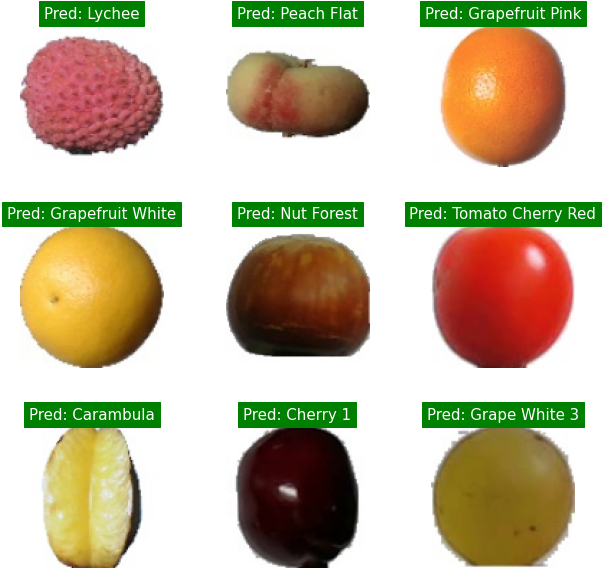

In [10]:
with torch.set_grad_enabled(False):     # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, device)
    print(f'test acc: {test_acc:.4f}')
    y_true, y_pred = get_true_and_pred_labels(model, test_loader, device)
    class_names = [f'class {i}' for i in range(num_class)]
    report = get_classification_report(y_true, y_pred, class_names)
    print(report)
    check_accuracy(test_loader, test_dataset, num_class, model)
    visualize_model(3,3,test_dataset, y_pred)

with open('classification_report_fruit_vgg16.txt', 'w') as f:
    f.write(report)